<center><h1>Wong_Jonathan_HW7</h1></center>

Name: Jonathan Wong
<br>
Github Username: jonathanwong150
<br>
USC ID: 9171949586
<br>
1 Late Day Used

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [28]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

### (a) Download the Anuran Calls (MFCCs) Data Set

In [23]:
df = pd.read_csv("../data/MFCCs/Frogs_MFCCs.csv")
trainDf, testDf = train_test_split(df, test_size=0.3, random_state=25)

print(trainDf.shape)
print(testDf.shape)

(5036, 26)
(2159, 26)


### (b) Train a classifier for each label

#### (i) Research

Exact Match: requires that the set of labels predicted for a sample must exactly match the corresponding set of true labels. This method does not consider partially correct predictions and marks them as incorrect if not all labels are correctly predicted​​​​.


Hamming Score/Loss: hamming score considers partially correct predictions. Hamming Loss, on the other hand, is the fraction of labels that are incorrectly predicted. Unlike the exact match metric, Hamming Loss penalizes only the individual labels.

#### (ii) Train a SVM for each of the labels

In [24]:
# Separate features and labels
X = trainDf.drop(['Family', 'Genus', 'Species'], axis=1)
y = trainDf[['Family', 'Genus', 'Species']]

scaler = StandardScaler()

def trainSVM(xTrain, y_train, standard=True):
    if standard:
        xTrain = scaler.fit_transform(xTrain)

    paramGrid = {
        'C': np.logspace(-3, 3, 7),  # SVM penalty
        'gamma': np.logspace(-3, 3, 7)  # Gaussian kernel
    }

    gridSearch = GridSearchCV(SVC(kernel='rbf'), paramGrid, cv=10, scoring=make_scorer(accuracy_score))
    gridSearch.fit(xTrain, y_train)

    return gridSearch.best_estimator_, gridSearch.best_params_

models = {}
params = {}

for label in y.columns:
    model, bestParams = trainSVM(X, y[label])
    models[label] = model
    params[label] = bestParams
    print(f"Best parameters for {label}: {bestParams}")

Best parameters for Family: {'C': 1000.0, 'gamma': 0.01}
Best parameters for Genus: {'C': 100.0, 'gamma': 0.01}
Best parameters for Species: {'C': 100.0, 'gamma': 0.001}


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [29]:
xStandard = scaler.fit_transform(X)

def trainL1(xTrain, y_train):
    paramGrid = {
        'C': np.logspace(-3, 3, 7)  # SVM penalty
    }

    gridSearch = GridSearchCV(LinearSVC(penalty='l1', dual=False, max_iter=10000), paramGrid, cv=10, scoring=make_scorer(accuracy_score))
    gridSearch.fit(xTrain, y_train)

    return gridSearch.best_estimator_, gridSearch.best_params_

modelsL1 = {}
paramsL1 = {}

for label in y.columns:
    model, bestParams = trainL1(xStandard, y[label])
    modelsL1[label] = model
    paramsL1[label] = bestParams
    print(f"Best parameters for {label} (L1-penalized SVM): {bestParams}")


Best parameters for Family (L1-penalized SVM): {'C': 1000.0}
Best parameters for Genus (L1-penalized SVM): {'C': 10.0}
Best parameters for Species (L1-penalized SVM): {'C': 10.0}


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [30]:
smote = SMOTE()

# Apply SMOTE for each label
xSmote = {}
ySmote = {}
for label in y.columns:
    xSm, ySm = smote.fit_resample(xStandard, y[label])
    xSmote[label] = xSm
    ySmote[label] = ySm

modelsSmoteL1 = {}
paramsSmoteL1 = {}

for label in y.columns:
    model, bestParams = trainL1(xSmote[label], ySmote[label])
    modelsSmoteL1[label] = model
    paramsSmoteL1[label] = bestParams
    print(f"Best parameters for {label} (L1-penalized SVM with SMOTE): {bestParams}")

Best parameters for Family (L1-penalized SVM with SMOTE): {'C': 100.0}
Best parameters for Genus (L1-penalized SVM with SMOTE): {'C': 100.0}
Best parameters for Species (L1-penalized SVM with SMOTE): {'C': 1000.0}


## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [32]:
xFull = df.drop(['Family', 'Genus', 'Species'], axis=1)
xStandard = scaler.fit_transform(xFull)

silhouetteScores = []
for k in range(1, 51):
    if k == 1:
        silhouetteScores.append(-1)
        continue
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(xStandard)
    score = silhouette_score(xStandard, kmeans.labels_)
    silhouetteScores.append(score)

# Determine the optimal k
kOptimal = silhouetteScores.index(max(silhouetteScores)) + 1
print(f"Optimal number of clusters: {kOptimal}")

def hammingDistance(labels, clusters):
    assert len(labels) == len(clusters)
    return np.mean(labels != clusters)

hammingDistances = []
for k in range(1, 51):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(xStandard)
    hamming_dist = hammingDistance(df['Species'], kmeans.labels_)
    hammingDistances.append(hamming_dist)

avgHamming = np.mean(hammingDistances)
stdHamming = np.std(hammingDistances)

print(f"Average Hamming Distance: {avgHamming}")
print(f"Standard Deviation of Hamming Distances: {stdHamming}")

Optimal number of clusters: 4
Average Hamming Distance: 1.0
Standard Deviation of Hamming Distances: 0.0


### (b) Determine which family is the majority

In [33]:
# Perform k-means clustering with the optimal number of clusters
kMeansOptimal = KMeans(n_clusters=kOptimal, random_state=25)
clusters = kMeansOptimal.fit_predict(xStandard)

df['Cluster'] = clusters

# Initialize dictionaries to store the majority classes
majorityFamily = {}
majorityGenus = {}
majoritySpecies = {}

for k in range(kOptimal):
    clusterData = df[df['Cluster'] == k]
    
    # Find majority family, genus, and species in the cluster
    majorityFamily[k] = clusterData['Family'].mode()[0]
    majorityGenus[k] = clusterData['Genus'].mode()[0]
    majoritySpecies[k] = clusterData['Species'].mode()[0]

print("Majority Class in Each Cluster:")
for k in range(kOptimal):
    print(f"Cluster {k}: Family: {majorityFamily[k]}, Genus: {majorityGenus[k]}, Species: {majoritySpecies[k]}")


Majority Class in Each Cluster:
Cluster 0: Family: Leptodactylidae, Genus: Adenomera, Species: AdenomeraHylaedactylus
Cluster 1: Family: Leptodactylidae, Genus: Adenomera, Species: AdenomeraAndre
Cluster 2: Family: Leptodactylidae, Genus: Adenomera, Species: AdenomeraAndre
Cluster 3: Family: Hylidae, Genus: Hypsiboas, Species: HypsiboasCordobae


### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [34]:
def calcHammingMetrics(df, majorityLabels):
    totInstances = len(df)
    totLabels = 3 * totInstances

    sumHamming = 0
    correctPred = 0

    for _, row in df.iterrows():
        cluster = row['Cluster']
        trueLabels = [row['Family'], row['Genus'], row['Species']]
        predicted_labels = majorityLabels[cluster]

        sumHamming += sum(t != p for t, p in zip(trueLabels, predicted_labels))
        correctPred += sum(t == p for t, p in zip(trueLabels, predicted_labels))

    # Calculate metrics
    avgHamming = sumHamming / totLabels
    hammingScore = correctPred / totLabels
    hammingLoss = 1 - hammingScore

    return avgHamming, hammingScore, hammingLoss

majorityLabels = {k: (majorityFamily[k], majorityGenus[k], majoritySpecies[k]) for k in range(kOptimal)}

avgHamming, hammingScore, hammingLoss = calcHammingMetrics(df, majorityLabels)

print(f"Average Hamming Distance: {avgHamming}")
print(f"Hamming Score: {hammingScore}")
print(f"Hamming Loss: {hammingLoss}")


Average Hamming Distance: 0.21232337271253185
Hamming Score: 0.7876766272874681
Hamming Loss: 0.21232337271253188


## 3. ISLR 12.6.2

a) ![Alt text](image.png)

b) 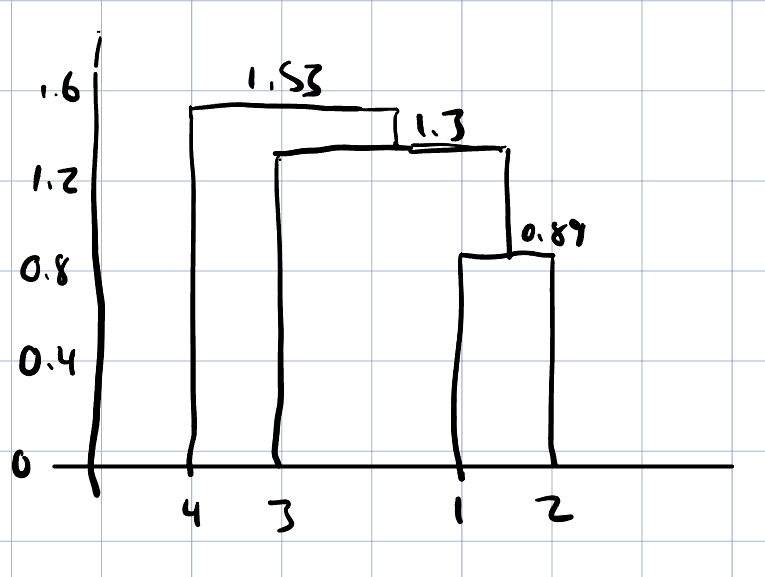

c) {1,2} and {3,4}

d) {1,2,3} and {4}

e) 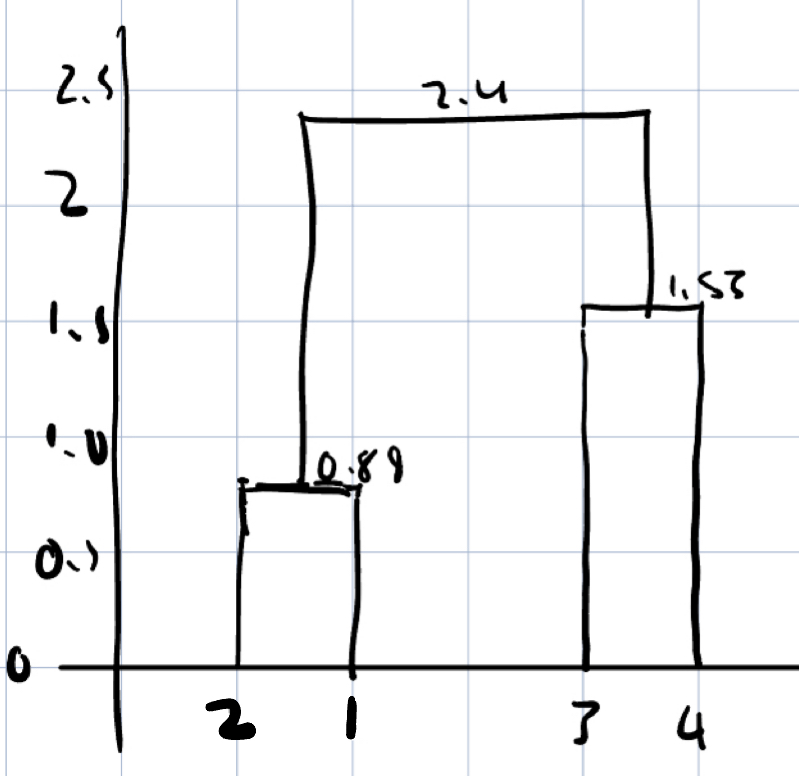